In [1]:
import torch.nn    as nn
import torch.optim as optim
import GM_library  as GML
import numpy       as np
import torch

from os                   import path, listdir
from torch.utils.data     import random_split
from torch_geometric.data import Data

import sys
sys.path.append('../')
import MP.MP_library as MPL

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Define target value to look for
#seeked_target = ##

# Machine-learning parameters
n_epochs      = 1000
batch_size    = 128
learning_rate = 0.0001

# Number of diffusing and denoising steps, which can be different
n_diffusing_steps = 2
n_denoising_steps = 2

# Decay of parameter alpha
noise_contribution = 0.15
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.2
dropout_edge = 0.2

# Define box shape
L = [50, 50, 50]

# Target to generate new crystals
target = 'GM_EPA_Mac_2'

# In case database is created from scratch (otherwise, it is not being used)
DB_path = '../MP/Loaded_EMP'

input_folder    = 'models'
target_folder   = f'{input_folder}/{target}'
edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'

# Generation of graph database for training

Load the datasets, already standarized if possible.

In [11]:
import importlib
importlib.reload(GML)

<module 'GM_library' from '/Users/cibran/Work/UPC/GenerativeModels/GM_library.py'>

In [13]:
labels_name         = f'{target_folder}/labels.pt'
dataset_name        = f'{target_folder}/dataset.pt'
dataset_name_std    = f'{target_folder}/standardized_dataset.pt'
parameters_name_std = f'{target_folder}/standardized_parameters.pt'  # Parameters for rescaling the predictions

if path.exists(dataset_name_std) and path.exists(parameters_name_std):  # and path.exists(labels_name)
    # Load the standardized dataset, with corresponding labels and parameters
    dataset    = torch.load(dataset_name_std)
    labels     = torch.load(labels_name)
    parameters = torch.load(parameters_name_std)

    # Assigning parameters accordingly
    target_mean, feat_mean, edge_mean, target_std, edge_std, feat_std, scale = parameters
    
    # Defining target factor
    target_factor = target_std / scale

elif path.exists(dataset_name) and path.exists(labels_name):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, parameters = GML.standardize_dataset(dataset, labels)
    
    # Save standardized dataset
    torch.save(dataset,    dataset_name_std)
    torch.save(parameters, parameters_name_std)

else:
    # Generate the raw dataset from scratch, and standardize it
    
    # Read all mateials within the database
    materials = listdir(DB_path)[:14]
    
    dataset = []
    labels  = []
    for material in materials:
        try:
            # Try to read the polyforms
            polymorfs = listdir(f'{DB_path}/{material}')
        except:
            continue
        
        print(material)
        for polymorf in polymorfs:
            # Path to folder containing the POSCAR
            path_to_POSCAR = f'{DB_path}/{material}/{polymorf}'
            
            # Check that the folder is valid
            if path.exists(f'{path_to_POSCAR}/POSCAR'):
                print(f'\t{polymorf}')

                # Extract parameters from POSCAR
                cell, composition, concentration, positions = MPL.information_from_VASPfile(path_to_POSCAR,
                                                                                            'POSCAR')

                # Generate POSCAR covering the box
                try:
                    nodes, edges, attributes = GML.graph_POSCAR_encoding(cell, composition, concentration, positions, L)
                except:
                    print(f'Error: {material} {polymorf} not loaded')
                    continue

                # Load ground state energy per atom
                gs_energy = float(np.loadtxt(f'{path_to_POSCAR}/EPA'))

                # Construct temporal graph structure
                graph = Data(x=nodes,
                             edge_index=edges,
                             edge_attr=attributes,
                             y=torch.tensor([[gs_energy]], dtype=torch.float)
                            )

                # Append to dataset and labels
                dataset.append(graph)
                labels.append(f'{material}-{polymorf}')
    
    # Standardize dataset
    dataset, parameters = GML.standardize_dataset(dataset, labels)
    
    # Save standardized dataset
    torch.save(dataset,    dataset_name_std)
    torch.save(parameters, parameters_name_std)
    torch.save(labels,     labels_name)

Sr2LiCBr3N2
	Fd-3m
aa
[0.789159 0.403614 0.403614]

[0, 0, 0]
[5.95826369 8.80402569 8.80402569]

[0, 0, 1]
[13.33940469 16.18516669  8.80402569]

[0, 0, 2]
[20.72054569 23.56630769  8.80402569]

[0, 0, 3]
[28.10168669 30.94744869  8.80402569]

[0, 0, 4]
[35.48282769 38.32858969  8.80402569]

[0, 0, 5]
[42.86396869 45.70973069  8.80402569]

[0, 0, 6]
Hey [50.24510969 53.09087169  8.80402569]

[0, 0, -1]
Hey [-1.42287731  1.42288469  8.80402569]

[0, 0, -2]
Hey [-8.80401831 -5.95825631  8.80402569]

[0, 1, 0]
[13.33940469  8.80402569 16.18516669]

[0, 1, 1]
[20.72054569 16.18516669 16.18516669]

[0, 1, 2]
[28.10168669 23.56630769 16.18516669]

[0, 1, 3]
[35.48282769 30.94744869 16.18516669]

[0, 1, 4]
[42.86396869 38.32858969 16.18516669]

[0, 1, 5]
Hey [50.24510969 45.70973069 16.18516669]

[0, 1, -1]
[ 5.95826369  1.42288469 16.18516669]

[0, 1, -2]
Hey [-1.42287731 -5.95825631 16.18516669]

[0, -1, 0]
Hey [-1.42287731  8.80402569  1.42288469]

[0, -1, 1]
[ 5.95826369 16.18516669  1.4

Hey [-5.53585575 12.91699675 20.29813775]

[2, 0, -2]
Hey [-12.91699675   5.53585575  20.29813775]

[2, 1, 0]
[ 9.22642625 20.29813775 27.67927875]

[2, 1, 1]
[16.60756725 27.67927875 27.67927875]

[2, 1, 2]
[23.98870825 35.06041975 27.67927875]

[2, 1, 3]
[31.36984925 42.44156075 27.67927875]

[2, 1, 4]
[38.75099025 49.82270175 27.67927875]

[2, 1, 5]
Hey [46.13213125 57.20384275 27.67927875]

[2, 1, -1]
[ 1.84528525 12.91699675 27.67927875]

[2, 1, -2]
Hey [-5.53585575  5.53585575 27.67927875]

[2, 2, 0]
[16.60756725 20.29813775 35.06041975]

[2, 2, 1]
[23.98870825 27.67927875 35.06041975]

[2, 2, 2]
[31.36984925 35.06041975 35.06041975]

[2, 2, 3]
[38.75099025 42.44156075 35.06041975]

[2, 2, 4]
[46.13213125 49.82270175 35.06041975]

[2, 2, 5]
Hey [53.51327225 57.20384275 35.06041975]

[2, 2, -1]
[ 9.22642625 12.91699675 35.06041975]

[2, 2, -2]
[ 1.84528525  5.53585575 35.06041975]

[2, 2, -3]
Hey [-5.53585575 -1.84528525 35.06041975]

[2, 3, 0]
[23.98870825 20.29813775 42.44156075


[1, 1, 0]
[14.762282   14.762282   26.63196865]

[1, 1, 1]
[22.143423   22.143423   26.63196865]

[1, 1, 2]
[29.524564   29.524564   26.63196865]

[1, 1, 3]
[36.905705   36.905705   26.63196865]

[1, 1, 4]
[44.286846   44.286846   26.63196865]

[1, 1, 5]
Hey [51.667987   51.667987   26.63196865]

[1, 1, -1]
[ 7.381141    7.381141   26.63196865]

[1, 1, -2]
[ 0.          0.         26.63196865]

[1, 1, -3]
Hey [-7.381141   -7.381141   26.63196865]

[1, -1, 0]
Hey [-2.22044605e-16  1.47622820e+01  1.18696867e+01]

[1, -1, 1]
[ 7.381141   22.143423   11.86968665]

[1, -1, 2]
[14.762282   29.524564   11.86968665]

[1, -1, 3]
[22.143423   36.905705   11.86968665]

[1, -1, 4]
[29.524564   44.286846   11.86968665]

[1, -1, 5]
Hey [36.905705   51.667987   11.86968665]

[1, -1, -1]
Hey [-7.381141    7.381141   11.86968665]

[1, -1, -2]
Hey [-14.762282     0.          11.86968665]

[1, -2, 0]
Hey [-7.381141   14.762282    4.48854565]

[1, -2, 1]
[ 0.         22.143423    4.48854565]

[1, -2, 2]

Hey [ 14.762282   -19.25082765   7.381141  ]

[-2, 2, -2]
Hey [  7.381141   -26.63196865   7.381141  ]

[-2, -1, 0]
Hey [-2.22044605e-16 -1.18696867e+01 -1.47622820e+01]

[-2, -1, 1]
Hey [  7.381141    -4.48854565 -14.762282  ]

[-2, -1, -1]
Hey [ -7.381141   -19.25082765 -14.762282  ]

[-2, -1, -2]
Hey [-14.762282   -26.63196865 -14.762282  ]

[-2, -2, 0]
Hey [ -7.381141   -11.86968665 -22.143423  ]

[-2, -2, 1]
Hey [  0.          -4.48854565 -22.143423  ]

[-2, -2, 2]
Hey [  7.381141     2.89259535 -22.143423  ]

[-2, -2, -1]
Hey [-14.762282   -19.25082765 -22.143423  ]

[-2, -2, -2]
Hey [-22.143423   -26.63196865 -22.143423  ]
aa
[0.054055 0.054055 0.445945]

[0, 0, 0]
[3.6905705  3.6905705  0.79797515]

[0, 0, 1]
[11.0717115  11.0717115   0.79797515]

[0, 0, 2]
[18.4528525  18.4528525   0.79797515]

[0, 0, 3]
[25.8339935  25.8339935   0.79797515]

[0, 0, 4]
[33.2151345  33.2151345   0.79797515]

[0, 0, 5]
[40.5962755  40.5962755   0.79797515]

[0, 0, 6]
[47.9774165  47.9774165   0.

Error: Sr2LiCBr3N2 Fd-3m not loaded
LiUNbO6
	P2_1-c
aa
[0.002396 0.179047 0.001827]

[0, 0, 0]
[0.01556277 1.36867113 0.01872162]

[0, 0, 1]
[ 0.01556277  3.30087913 10.26591462]

[0, 0, 2]
[1.55627747e-02 5.23308713e+00 2.05131076e+01]

[0, 0, 3]
[1.55627747e-02 7.16529513e+00 3.07603006e+01]

[0, 0, 4]
[1.55627747e-02 9.09750313e+00 4.10074936e+01]

[0, 0, 5]
Hey [1.55627747e-02 1.10297111e+01 5.12546866e+01]

[0, 0, -1]
Hey [  0.01556277  -0.56353687 -10.22847138]

[0, 0, -2]
Hey [ 1.55627747e-02 -2.49574487e+00 -2.04756644e+01]

[0, 1, 0]
[0.01556277 8.99315513 0.01872162]

[0, 1, 1]
[ 0.01556277 10.92536313 10.26591462]

[0, 1, 2]
[1.55627747e-02 1.28575711e+01 2.05131076e+01]

[0, 1, 3]
[1.55627747e-02 1.47897791e+01 3.07603006e+01]

[0, 1, 4]
[1.55627747e-02 1.67219871e+01 4.10074936e+01]

[0, 1, 5]
Hey [1.55627747e-02 1.86541951e+01 5.12546866e+01]

[0, 1, -1]
Hey [  0.01556277   7.06094713 -10.22847138]

[0, 1, -2]
Hey [ 1.55627747e-02  5.12873913e+00 -2.04756644e+01]

[0, -1,

Hey [ 0.35817116  0.28098326 -7.20810099]

[0, 0, -2]
Hey [  0.35817116  -1.65122474 -17.45529399]

[0, 1, 0]
[0.35817116 9.83767526 3.03909201]

[0, 1, 1]
[ 0.35817116 11.76988326 13.28628501]

[0, 1, 2]
[ 0.35817116 13.70209126 23.53347801]

[0, 1, 3]
[ 0.35817116 15.63429926 33.78067101]

[0, 1, 4]
[ 0.35817116 17.56650726 44.02786401]

[0, 1, 5]
Hey [ 0.35817116 19.49871526 54.27505701]

[0, 1, -1]
Hey [ 0.35817116  7.90546726 -7.20810099]

[0, 1, -2]
Hey [  0.35817116   5.97325926 -17.45529399]

[0, -1, 0]
Hey [ 0.35817116 -5.41129274  3.03909201]

[0, -1, 1]
Hey [ 0.35817116 -3.47908474 13.28628501]

[0, -1, -1]
Hey [ 0.35817116 -7.34350074 -7.20810099]

[0, -1, -2]
Hey [  0.35817116  -9.27570874 -17.45529399]

[0, -2, 0]
Hey [  0.35817116 -13.03577674   3.03909201]

[0, -2, 1]
Hey [  0.35817116 -11.10356874  13.28628501]

[0, -2, -1]
Hey [  0.35817116 -14.96798474  -7.20810099]

[0, -2, -2]
Hey [  0.35817116 -16.90019274 -17.45529399]

[1, 0, 0]
[6.85348616 2.21319126 3.03909201

NaCo(PO3)3
	I-43d
aa
[0.71956162 0.71956162 0.71956162]

[0, 0, 0]
Hey [-5.31627584 -5.31627584 -5.31627584]

[0, 0, 1]
Hey [  2.071939   -12.70449068 -12.70449068]

[0, 0, -1]
Hey [-12.70449068   2.071939     2.071939  ]

[0, 0, -2]
Hey [-20.09270552   9.46015384   9.46015384]

[0, 1, 0]
Hey [-12.70449068   2.071939   -12.70449068]

[0, 1, 1]
Hey [ -5.31627584  -5.31627584 -20.09270552]

[0, 1, -1]
Hey [-20.09270552   9.46015384  -5.31627584]

[0, 1, -2]
Hey [-27.48092036  16.84836868   2.071939  ]

[0, -1, 0]
Hey [  2.071939   -12.70449068   2.071939  ]

[0, -1, 1]
Hey [  9.46015384 -20.09270552  -5.31627584]

[0, -1, -1]
Hey [-5.31627584 -5.31627584  9.46015384]

[0, -1, -2]
Hey [-12.70449068   2.071939    16.84836868]

[0, -2, 0]
Hey [  9.46015384 -20.09270552   9.46015384]

[0, -2, 1]
Hey [ 16.84836868 -27.48092036   2.071939  ]

[0, -2, -1]
Hey [  2.071939   -12.70449068  16.84836868]

[0, -2, -2]
Hey [-5.31627584 -5.31627584 24.23658352]

[1, 0, 0]
Hey [-12.70449068 -12.70449068

Hey [ 10.85918251 -26.08189169   3.91724717]

[1, -1, -1]
Hey [ -3.91724717 -11.30546201  18.69367685]

[1, -1, -2]
Hey [-11.30546201  -3.91724717  26.08189169]

[1, -2, 0]
Hey [ 10.85918251 -26.08189169  18.69367685]

[1, -2, 1]
Hey [ 18.24739735 -33.47010653  11.30546201]

[1, -2, -1]
Hey [  3.47096767 -18.69367685  26.08189169]

[1, -2, -2]
Hey [ -3.91724717 -11.30546201  33.47010653]

[1, -2, -3]
Hey [-11.30546201  -3.91724717  40.85832137]

[1, -2, -4]
Hey [-18.69367685   3.47096767  48.24653621]

[1, -2, -5]
Hey [-26.08189169  10.85918251  55.63475105]

[-1, 0, 0]
Hey [ 10.85918251   3.47096767 -10.85918251]

[-1, 0, 1]
Hey [ 18.24739735  -3.91724717 -18.24739735]

[-1, 0, -1]
Hey [ 3.47096767 10.85918251 -3.47096767]

[-1, 0, -2]
Hey [-3.91724717 18.24739735  3.91724717]

[-1, 1, 0]
Hey [  3.47096767  10.85918251 -18.24739735]

[-1, 1, 1]
Hey [ 10.85918251   3.47096767 -25.63561219]

[-1, 1, -1]
Hey [ -3.91724717  18.24739735 -10.85918251]

[-1, 1, -2]
Hey [-11.30546201  25.6356

Hey [-20.07670582  15.93170245   9.40086349]

[0, 1, 0]
Hey [-12.68849098   8.54348761 -12.76378103]

[0, 1, 1]
Hey [ -5.30027614   1.15527277 -20.15199587]

[0, 1, 2]
Hey [  2.0879387   -6.23294207 -27.54021071]

[0, 1, -1]
Hey [-20.07670582  15.93170245  -5.37556619]

[0, 1, -2]
Hey [-27.46492066  23.31991729   2.01264865]

[0, -1, 0]
Hey [ 2.0879387  -6.23294207  2.01264865]

[0, -1, 1]
Hey [  9.47615354 -13.62115691  -5.37556619]

[0, -1, -1]
Hey [-5.30027614  1.15527277  9.40086349]

[0, -1, -2]
Hey [-12.68849098   8.54348761  16.78907833]

[0, -2, 0]
Hey [  9.47615354 -13.62115691   9.40086349]

[0, -2, 1]
Hey [ 16.86436838 -21.00937175   2.01264865]

[0, -2, -1]
Hey [ 2.0879387  -6.23294207 16.78907833]

[0, -2, -2]
Hey [-5.30027614  1.15527277 24.17729317]

[0, -3, 0]
Hey [ 16.86436838 -21.00937175  16.78907833]

[0, -3, 1]
Hey [ 24.25258322 -28.39758659   9.40086349]

[0, -3, -1]
Hey [  9.47615354 -13.62115691  24.17729317]

[0, -3, -2]
Hey [ 2.0879387  -6.23294207 31.56550801

Hey [ 21.81240259   9.00574161 -20.4441776 ]

[-3, -1, 1]
Hey [ 29.20061743   1.61752677 -27.83239244]

[-3, -1, 2]
Hey [ 36.58883227  -5.77068807 -35.22060728]

[-3, -1, -1]
Hey [ 14.42418775  16.39395645 -13.05596276]

[-3, -1, -2]
Hey [ 7.03597291 23.78217129 -5.66774792]

[-3, -1, -3]
Hey [-0.35224193 31.17038613  1.72046692]

[-3, -1, -4]
Hey [-7.74045677 38.55860097  9.10868176]

[-3, -2, 0]
Hey [ 29.20061743   1.61752677 -13.05596276]

[-3, -2, 1]
Hey [ 36.58883227  -5.77068807 -20.4441776 ]

[-3, -2, -1]
Hey [21.81240259  9.00574161 -5.66774792]

[-3, -2, -2]
[14.42418775 16.39395645  1.72046692]

[-3, -2, -3]
[ 7.03597291 23.78217129  9.10868176]

[-3, -2, -4]
Hey [-0.35224193 31.17038613 16.4968966 ]
aa
[0.13330477 0.64027128 0.72589988]

[0, 0, 0]
Hey [-0.35224179 -1.61752677 -9.10868176]

[0, 0, 1]
Hey [  7.03597305  -9.00574161 -16.4968966 ]

[0, 0, -1]
Hey [-7.74045663  5.77068807 -1.72046692]

[0, 0, -2]
Hey [-15.12867147  13.15890291   5.66774792]

[0, 1, 0]
Hey [ -7.74


[-1, 0, 1]
Hey [ 10.73008047   1.9736405  -20.08806387]

[-1, 0, -1]
Hey [-4.04634921 16.75007018 -5.31163419]

[-1, 0, -2]
Hey [-11.43456405  24.13828502   2.07658065]

[-1, 1, 0]
Hey [ -4.04634921  16.75007018 -20.08806387]

[-1, 1, 1]
Hey [  3.34186563   9.36185534 -27.47627871]

[-1, 1, 2]
Hey [ 10.73008047   1.9736405  -34.86449355]

[-1, 1, -1]
Hey [-11.43456405  24.13828502 -12.69984903]

[-1, 1, -2]
Hey [-18.82277889  31.52649986  -5.31163419]

[-1, 1, -3]
Hey [-26.21099373  38.9147147    2.07658065]

[-1, 1, -4]
Hey [-33.59920857  46.30292954   9.46479549]

[-1, -1, 0]
Hey [10.73008047  1.9736405  -5.31163419]

[-1, -1, 1]
Hey [ 18.11829531  -5.41457434 -12.69984903]

[-1, -1, -1]
[3.34186563 9.36185534 2.07658065]

[-1, -1, -2]
Hey [-4.04634921 16.75007018  9.46479549]

[-1, -2, 0]
Hey [18.11829531 -5.41457434  2.07658065]

[-1, -2, 1]
Hey [ 25.50651015 -12.80278918  -5.31163419]

[-1, -2, -1]
[10.73008047  1.9736405   9.46479549]

[-1, -2, -2]
[ 3.34186563  9.36185534 16.85

Hey [ 1.9736405   9.46479549 69.83579919]

[-2, 0, 0]
Hey [ 16.75007018   9.46479549 -18.82277889]

[-2, 0, 1]
Hey [ 24.13828502   2.07658065 -26.21099373]

[-2, 0, -1]
Hey [  9.36185534  16.85301033 -11.43456405]

[-2, 0, -2]
Hey [ 1.9736405  24.24122517 -4.04634921]

[-2, 0, -3]
Hey [-5.41457434 31.62944001  3.34186563]

[-2, 0, -4]
Hey [-12.80278918  39.01765485  10.73008047]

[-2, 1, 0]
Hey [  9.36185534  16.85301033 -26.21099373]

[-2, 1, 1]
Hey [ 16.75007018   9.46479549 -33.59920857]

[-2, 1, -1]
Hey [  1.9736405   24.24122517 -18.82277889]

[-2, 1, -2]
Hey [ -5.41457434  31.62944001 -11.43456405]

[-2, 1, -3]
Hey [-12.80278918  39.01765485  -4.04634921]

[-2, 1, -4]
Hey [-20.19100402  46.40586969   3.34186563]

[-2, 1, -5]
Hey [-27.57921886  53.79408453  10.73008047]

[-2, -1, 0]
Hey [ 24.13828502   2.07658065 -11.43456405]

[-2, -1, 1]
Hey [ 31.52649986  -5.31163419 -18.82277889]

[-2, -1, -1]
Hey [16.75007018  9.46479549 -4.04634921]

[-2, -1, -2]
[ 9.36185534 16.85301033  3.


[0, -1, 1]
Hey [ 10.69076039 -21.00798026   1.45232141]

[0, -1, -1]
Hey [-4.08566929 -6.23155058 16.22875109]

[0, -1, -2]
Hey [-11.47388413   1.15666426  23.61696593]

[0, -2, 0]
Hey [ 10.69076039 -21.00798026  16.22875109]

[0, -2, 1]
Hey [ 18.07897523 -28.3961951    8.84053625]

[0, -2, -1]
Hey [  3.30254555 -13.61976542  23.61696593]

[0, -2, -2]
Hey [-4.08566929 -6.23155058 31.00518077]

[0, -2, -3]
Hey [-11.47388413   1.15666426  38.39339561]

[0, -2, -4]
Hey [-18.86209897   8.5448791   45.78161045]

[0, -3, 0]
Hey [ 18.07897523 -28.3961951   23.61696593]

[0, -3, 1]
Hey [ 25.46719007 -35.78440994  16.22875109]

[0, -3, -1]
Hey [ 10.69076039 -21.00798026  31.00518077]

[0, -3, -2]
Hey [  3.30254555 -13.61976542  38.39339561]

[0, -3, -3]
Hey [-4.08566929 -6.23155058 45.78161045]

[0, -3, -4]
Hey [-11.47388413   1.15666426  53.16982529]

[0, -4, 0]
Hey [ 25.46719007 -35.78440994  31.00518077]

[0, -4, 1]
Hey [ 32.85540491 -43.17262478  23.61696593]

[0, -4, -1]
Hey [ 18.07897523


[-2, 0, 0]
Hey [ 14.38486789   9.63000092 -19.62720144]

[-2, 0, 1]
Hey [ 21.77308273   2.24178608 -27.01541628]

[-2, 0, -1]
Hey [  6.99665305  17.01821576 -12.2389866 ]

[-2, 0, -2]
Hey [-0.39156179 24.4064306  -4.85077176]

[-2, 0, -3]
Hey [-7.77977663 31.79464544  2.53744308]

[-2, 0, -4]
Hey [-15.16799147  39.18286028   9.92565792]

[-2, 1, 0]
Hey [  6.99665305  17.01821576 -27.01541628]

[-2, 1, 1]
Hey [ 14.38486789   9.63000092 -34.40363112]

[-2, 1, -1]
Hey [ -0.39156179  24.4064306  -19.62720144]

[-2, 1, -2]
Hey [ -7.77977663  31.79464544 -12.2389866 ]

[-2, 1, -3]
Hey [-15.16799147  39.18286028  -4.85077176]

[-2, 1, -4]
Hey [-22.55620631  46.57107512   2.53744308]

[-2, 1, -5]
Hey [-29.94442115  53.95928996   9.92565792]

[-2, -1, 0]
Hey [ 21.77308273   2.24178608 -12.2389866 ]

[-2, -1, 1]
Hey [ 29.16129757  -5.14642876 -19.62720144]

[-2, -1, -1]
Hey [14.38486789  9.63000092 -4.85077176]

[-2, -1, -2]
[ 6.99665305 17.01821576  2.53744308]

[-2, -1, -3]
Hey [-0.39156179 2


[0, -1, 7]
[30.328445 34.66108   0.      ]

[0, -1, 8]
[34.66108  38.993715  0.      ]

[0, -1, 9]
[38.993715 43.32635   0.      ]

[0, -1, 10]
[43.32635  47.658985  0.      ]

[0, -1, 11]
Hey [47.658985 51.99162   0.      ]

[0, -1, -1]
Hey [-4.332635  0.        0.      ]

[0, -1, -2]
Hey [-8.66527  -4.332635  0.      ]

[0, -2, 0]
Hey [-4.332635  4.332635 -4.332635]

[0, -2, 1]
Hey [ 0.        8.66527  -4.332635]

[0, -2, -1]
Hey [-8.66527   0.       -4.332635]

[0, -2, -2]
Hey [-12.997905  -4.332635  -4.332635]

[1, 0, 0]
[4.332635 8.66527  8.66527 ]

[1, 0, 1]
[ 8.66527  12.997905  8.66527 ]

[1, 0, 2]
[12.997905 17.33054   8.66527 ]

[1, 0, 3]
[17.33054  21.663175  8.66527 ]

[1, 0, 4]
Error: Rb2NaTiF6 Fm-3m not loaded
Na6TeMo6(H22O23)2
	P-1
aa
[0.563395 0.237958 0.84187 ]

[0, 0, 0]
[1.23124632 1.37099797 8.44587641]

[0, 0, 1]
Hey [-3.43511668  0.07832397 18.47815741]

[0, 0, -1]
Hey [ 5.89760932  2.66367197 -1.58640459]

[0, 0, -2]
Hey [ 10.56397232   3.95634597 -11.61868559]


Hey [-5.67828   8.198533  4.855249]

[-1, 1, -1]
Hey [-5.67828   1.646321 -4.855249]

[-1, 1, -2]
Hey [-5.67828  -1.629785 -9.710498]

[-1, 2, 0]
Hey [-8.51742   9.844854  0.      ]

[-1, 2, 1]
Hey [-8.51742  13.12096   4.855249]

[-1, 2, -1]
Hey [-8.51742   6.568748 -4.855249]

[-1, 2, -2]
Hey [-8.51742   3.292642 -9.710498]

[-1, -1, 0]
Hey [ 0.       -4.922427  0.      ]

[-1, -1, 1]
Hey [ 0.       -1.646321  4.855249]

[-1, -1, -1]
Hey [ 0.       -8.198533 -4.855249]

[-1, -1, -2]
Hey [  0.       -11.474639  -9.710498]

[-1, -2, 0]
Hey [ 2.83914  -9.844854  0.      ]

[-1, -2, 1]
Hey [ 2.83914  -6.568748  4.855249]

[-1, -2, -1]
Hey [  2.83914  -13.12096   -4.855249]

[-1, -2, -2]
Hey [  2.83914  -16.397066  -9.710498]

[-2, 0, 0]
Hey [-5.67828  -4.922427  0.      ]

[-2, 0, 1]
Hey [-5.67828  -1.646321  4.855249]

[-2, 0, -1]
Hey [-5.67828  -8.198533 -4.855249]

[-2, 0, -2]
Hey [ -5.67828  -11.474639  -9.710498]

[-2, 1, 0]
Hey [-8.51742  0.       0.     ]

[-2, 1, 1]
Hey [-8.51742

[ 8.51742    46.01108651 42.69758893]

[3, 0, 9]
[ 8.51742    49.28719251 47.55283793]

[3, 0, 10]
Hey [ 8.51742    52.56329851 52.40808693]

[3, 0, -1]
Hey [ 8.51742    16.52613251 -0.99965207]

[3, 0, -2]
Hey [ 8.51742    13.25002651 -5.85490107]

[3, 1, 0]
[ 5.67828    24.72466551  3.85559693]

[3, 1, 1]
[ 5.67828    28.00077151  8.71084593]

[3, 1, 2]
[ 5.67828    31.27687751 13.56609493]

[3, 1, 3]
[ 5.67828    34.55298351 18.42134393]

[3, 1, 4]
[ 5.67828    37.82908951 23.27659293]

[3, 1, 5]
[ 5.67828    41.10519551 28.13184193]

[3, 1, 6]
[ 5.67828    44.38130151 32.98709093]

[3, 1, 7]
[ 5.67828    47.65740751 37.84233993]

[3, 1, 8]
Hey [ 5.67828    50.93351351 42.69758893]

[3, 1, -1]
Hey [ 5.67828    21.44855951 -0.99965207]

[3, 1, -2]
Hey [ 5.67828    18.17245351 -5.85490107]

[3, -1, 0]
[11.35656    14.87981151  3.85559693]

[3, -1, 1]
[11.35656    18.15591751  8.71084593]

[3, -1, 2]
[11.35656    21.43202351 13.56609493]

[3, -1, 3]
[11.35656    24.70812951 18.42134393

Na3Ti8O16
	Pm
aa
[0.5      0.757302 0.346417]

[0, 0, 0]
[1.4888795  7.04402958 3.74224966]

[0, 0, 1]
[ 1.4888795   7.06414658 14.54498066]

[0, 0, 2]
[ 1.4888795   7.08426358 25.34771166]

[0, 0, 3]
[ 1.4888795   7.10438058 36.15044266]

[0, 0, 4]
[ 1.4888795   7.12449758 46.95317366]

[0, 0, 5]
Hey [ 1.4888795   7.14461458 57.75590466]

[0, 0, -1]
Hey [ 1.4888795   7.02391258 -7.06048134]

[0, 0, -2]
Hey [  1.4888795    7.00379558 -17.86321234]

[0, 1, 0]
[ 1.4888795  16.33630758  3.74224966]

[0, 1, 1]
[ 1.4888795  16.35642458 14.54498066]

[0, 1, 2]
[ 1.4888795  16.37654158 25.34771166]

[0, 1, 3]
[ 1.4888795  16.39665858 36.15044266]

[0, 1, 4]
[ 1.4888795  16.41677558 46.95317366]

[0, 1, 5]
Hey [ 1.4888795  16.43689258 57.75590466]

[0, 1, -1]
Hey [ 1.4888795  16.31619058 -7.06048134]

[0, 1, -2]
Hey [  1.4888795   16.29607358 -17.86321234]

[0, -1, 0]
Hey [ 1.4888795  -2.24824842  3.74224966]

[0, -1, 1]
Hey [ 1.4888795  -2.22813142 14.54498066]

[0, -1, -1]
Hey [ 1.4888795  -

	Pmmn
aa
[0.5      0.622833 0.5     ]

[0, 0, 0]
[3.0627205 5.3950492 6.131981 ]

[0, 0, 1]
[ 3.0627205  5.3950492 18.395943 ]

[0, 0, 2]
[ 3.0627205  5.3950492 30.659905 ]

[0, 0, 3]
[ 3.0627205  5.3950492 42.923867 ]

[0, 0, 4]
Hey [ 3.0627205  5.3950492 55.187829 ]

[0, 0, -1]
Hey [ 3.0627205  5.3950492 -6.131981 ]

[0, 0, -2]
Hey [  3.0627205   5.3950492 -18.395943 ]

[0, 1, 0]
[ 3.0627205 14.0571612  6.131981 ]

[0, 1, 1]
[ 3.0627205 14.0571612 18.395943 ]

[0, 1, 2]
[ 3.0627205 14.0571612 30.659905 ]

[0, 1, 3]
[ 3.0627205 14.0571612 42.923867 ]

[0, 1, 4]
Hey [ 3.0627205 14.0571612 55.187829 ]

[0, 1, -1]
Hey [ 3.0627205 14.0571612 -6.131981 ]

[0, 1, -2]
Hey [  3.0627205  14.0571612 -18.395943 ]

[0, -1, 0]
Hey [ 3.0627205 -3.2670628  6.131981 ]

[0, -1, 1]
Hey [ 3.0627205 -3.2670628 18.395943 ]

[0, -1, -1]
Hey [ 3.0627205 -3.2670628 -6.131981 ]

[0, -1, -2]
Hey [  3.0627205  -3.2670628 -18.395943 ]

[0, -2, 0]
Hey [  3.0627205 -11.9291748   6.131981 ]

[0, -2, 1]
Hey [  3.062

[10.95046313 14.99718226 45.98052462]

[1, 1, 4]
Hey [10.95046313 14.99718226 58.24448662]

[1, 1, -1]
Hey [10.95046313 14.99718226 -3.07532338]

[1, 1, -2]
Hey [ 10.95046313  14.99718226 -15.33928538]

[1, -1, 0]
Hey [10.95046313 -2.32704174  9.18863862]

[1, -1, 1]
Hey [10.95046313 -2.32704174 21.45260062]

[1, -1, -1]
Hey [10.95046313 -2.32704174 -3.07532338]

[1, -1, -2]
Hey [ 10.95046313  -2.32704174 -15.33928538]

[1, -2, 0]
Hey [ 10.95046313 -10.98915374   9.18863862]

[1, -2, 1]
Hey [ 10.95046313 -10.98915374  21.45260062]

[1, -2, -1]
Hey [ 10.95046313 -10.98915374  -3.07532338]

[1, -2, -2]
Hey [ 10.95046313 -10.98915374 -15.33928538]

[-1, 0, 0]
Hey [-1.30041887  6.33507026  9.18863862]

[-1, 0, 1]
Hey [-1.30041887  6.33507026 21.45260062]

[-1, 0, -1]
Hey [-1.30041887  6.33507026 -3.07532338]

[-1, 0, -2]
Hey [ -1.30041887   6.33507026 -15.33928538]

[-1, 1, 0]
Hey [-1.30041887 14.99718226  9.18863862]

[-1, 1, 1]
Hey [-1.30041887 14.99718226 21.45260062]

[-1, 1, -1]
Hey [

Na5Ca2Ti2P5SO24
	P1
aa
[0.64302734 0.007603   0.25323992]

[0, 0, 0]
[5.81208292 0.06967167 5.66400297]

[0, 0, 1]
[ 5.87205293  0.07291357 27.9732802 ]

[0, 0, 2]
Hey [ 5.93202294  0.07615547 50.28255743]

[0, 0, -1]
Hey [  5.75211291   0.06642977 -16.64527426]

[0, 0, -2]
Hey [  5.6921429    0.06318787 -38.95455149]

[0, 1, 0]
[1.29024296 7.93085763 5.65386275]

[0, 1, 1]
[ 1.35021297  7.93409953 27.96313998]

[0, 1, 2]
Hey [ 1.41018298  7.93734143 50.27241721]

[0, 1, -1]
Hey [  1.23027295   7.92761573 -16.65541448]

[0, 1, -2]
Hey [  1.17030294   7.92437383 -38.96469171]

[0, -1, 0]
Hey [10.33392288 -7.79151429  5.67414319]

[0, -1, 1]
Hey [10.39389289 -7.78827239 27.98342042]

[0, -1, -1]
Hey [ 10.27395287  -7.79475619 -16.63513404]

[0, -1, -2]
Hey [ 10.21398286  -7.79799809 -38.94441127]

[0, -2, 0]
Hey [ 14.85576284 -15.65270025   5.68428341]

[0, -2, 1]
Hey [ 14.91573285 -15.64945835  27.99356064]

[0, -2, -1]
Hey [ 14.79579283 -15.65594215 -16.62499382]

[0, -2, -2]
Hey [ 14.

Hey [ 21.9215185  -11.48243688 -10.36943889]

[1, -2, -2]
Hey [ 21.86154849 -11.48567878 -32.67871612]

[-1, 0, 0]
Hey [-5.19913617  4.214929   11.87451944]

[-1, 0, 1]
Hey [-5.13916616  4.2181709  34.18379667]

[-1, 0, -1]
Hey [ -5.25910618   4.2116871  -10.43475779]

[-1, 0, -2]
Hey [ -5.31907619   4.2084452  -32.74403502]

[-1, 1, 0]
Hey [-9.72097613 12.07611496 11.86437922]

[-1, 1, 1]
Hey [-9.66100612 12.07935686 34.17365645]

[-1, 1, -1]
Hey [ -9.78094614  12.07287306 -10.44489801]

[-1, 1, -2]
Hey [ -9.84091615  12.06963116 -32.75417524]

[-1, -1, 0]
Hey [-0.67729621 -3.64625696 11.88465966]

[-1, -1, 1]
Hey [-0.6173262  -3.64301506 34.19393689]

[-1, -1, -1]
Hey [ -0.73726622  -3.64949886 -10.42461757]

[-1, -1, -2]
Hey [ -0.79723623  -3.65274076 -32.7338948 ]

[-1, -2, 0]
Hey [  3.84454375 -11.50744292  11.89479988]

[-1, -2, 1]
Hey [  3.90451376 -11.50420102  34.20407711]

[-1, -2, -1]
Hey [  3.78457374 -11.51068482 -10.41447735]

[-1, -2, -2]
Hey [  3.72460373 -11.51392672 -

Hey [-0.9433855  -6.72584566 27.78973052]

[-1, -1, -1]
Hey [ -1.06332552  -6.73232946 -16.82882394]

[-1, -1, -2]
Hey [ -1.12329553  -6.73557136 -39.13810117]

[-1, -2, 0]
Hey [  3.51848445 -14.59027352   5.49059351]

[-1, -2, 1]
Hey [  3.57845446 -14.58703162  27.79987074]

[-1, -2, -1]
Hey [  3.45851444 -14.59351542 -16.81868372]

[-1, -2, -2]
Hey [  3.39854443 -14.59675732 -39.12796095]

[-2, 0, 0]
Hey [-14.59366785   1.11797443   5.44779384]

[-2, 0, 1]
Hey [-14.53369784   1.12121633  27.75707107]

[-2, 0, -1]
Hey [-14.65363786   1.11473253 -16.86148339]

[-2, 0, -2]
Hey [-14.71360787   1.11149063 -39.17076062]

[-2, 1, 0]
Hey [-19.11550781   8.97916039   5.43765362]

[-2, 1, 1]
Hey [-19.0555378    8.98240229  27.74693085]

[-2, 1, -1]
Hey [-19.17547782   8.97591849 -16.87162361]

[-2, 1, -2]
Hey [-19.23544783   8.97267659 -39.18090084]

[-2, -1, 0]
Hey [-10.07182789  -6.74321153   5.45793406]

[-2, -1, 1]
Hey [-10.01185788  -6.73996963  27.76721129]

[-2, -1, -1]
Hey [-10.1317979


[1, -2, 0]
Hey [ 18.63610479 -11.96726129  16.84882983]

[1, -2, 1]
Hey [ 18.6960748  -11.96401939  39.15810706]

[1, -2, 2]
Hey [ 18.75604481 -11.96077749  61.46738429]

[1, -2, -1]
Hey [ 18.57613478 -11.97050319  -5.4604474 ]

[1, -2, -2]
Hey [ 18.51616477 -11.97374509 -27.76972463]

[-1, 0, 0]
Hey [-8.54451989  3.72686269 16.78351093]

[-1, 0, 1]
Hey [-8.48454988  3.73010459 39.09278816]

[-1, 0, 2]
Hey [-8.42457987  3.73334649 61.40206539]

[-1, 0, -1]
Hey [-8.6044899   3.72362079 -5.5257663 ]

[-1, 0, -2]
Hey [ -8.66445991   3.72037889 -27.83504353]

[-1, 1, 0]
Hey [-13.06635985  11.58804865  16.77337071]

[-1, 1, 1]
Hey [-13.00638984  11.59129055  39.08264794]

[-1, 1, 2]
Hey [-12.94641983  11.59453245  61.39192517]

[-1, 1, -1]
Hey [-13.12632986  11.58480675  -5.53590652]

[-1, 1, -2]
Hey [-13.18629987  11.58156485 -27.84518375]

[-1, -1, 0]
Hey [-4.02267993 -4.13432327 16.79365115]

[-1, -1, 1]
Hey [-3.96270992 -4.13108137 39.10292838]

[-1, -1, 2]
Hey [-3.90273991 -4.12783947

Na2(ReS2)3
	C2-c
aa
[0.5846008 0.4153992 0.25     ]

[0, 0, 0]
[0.81906952 8.10073584 2.92726591]

[0, 0, 1]
[ 0.81906952  8.70408749 14.47489227]

[0, 0, 2]
[ 0.81906952  9.30743915 26.02251863]

[0, 0, 3]
[ 0.81906952  9.91079081 37.57014499]

[0, 0, 4]
[ 0.81906952 10.51414247 49.11777135]

[0, 0, 5]
Hey [ 0.81906952 11.11749413 60.66539771]

[0, 0, -1]
Hey [ 0.81906952  7.49738417 -8.62036045]

[0, 0, -2]
Hey [  0.81906952   6.89403251 -20.16798681]

[0, 1, 0]
Hey [-4.02172112 16.05063375  2.96762523]

[0, 1, 1]
Hey [-4.02172112 16.65398542 14.51525159]

[0, 1, -1]
Hey [-4.02172112 15.4472821  -8.58000113]

[0, 1, -2]
Hey [ -4.02172112  14.84393043 -20.12762749]

[0, -1, 0]
[5.65986016 0.15083791 2.88690659]

[0, -1, 1]
[ 5.65986016  0.75418957 14.43453295]

[0, -1, 2]
[ 5.65986016  1.35754123 25.98215931]

[0, -1, 3]
[ 5.65986016  1.96089289 37.52978567]

[0, -1, 4]
[ 5.65986016  2.56424455 49.07741203]

[0, -1, 5]
Hey [ 5.65986016  3.16759621 60.62503839]

[0, -1, -1]
Hey [ 5.659

Hey [  3.09399492 -20.24103484 -21.68255393]

[-2, 0, 0]
Hey [-11.428377   -11.0844336    1.45305811]

[-2, 0, 1]
Hey [-11.428377   -10.48108194  13.00068447]

[-2, 0, -1]
Hey [-11.428377   -11.68778526 -10.09456825]

[-2, 0, -2]
Hey [-11.428377   -12.29113692 -21.64219461]

[-2, 1, 0]
Hey [-16.26916764  -3.13453568   1.49341743]

[-2, 1, 1]
Hey [-16.26916764  -2.53118402  13.04104379]

[-2, 1, -1]
Hey [-16.26916764  -3.73788734 -10.05420893]

[-2, 1, -2]
Hey [-16.26916764  -4.341239   -21.60183529]

[-2, 2, 0]
Hey [-21.10995828   4.81536224   1.53377675]

[-2, 2, 1]
Hey [-21.10995828   5.4187139   13.08140311]

[-2, 2, -1]
Hey [-21.10995828   4.21201058 -10.01384961]

[-2, 2, -2]
Hey [-21.10995828   3.60865892 -21.56147597]

[-2, -1, 0]
Hey [ -6.58758636 -19.03433152   1.41269879]

[-2, -1, 1]
Hey [ -6.58758636 -18.43097986  12.96032515]

[-2, -1, -1]
Hey [ -6.58758636 -19.63768318 -10.13492757]

[-2, -1, -2]
Hey [ -6.58758636 -20.24103484 -21.68255393]

[-2, -2, 0]
Hey [ -1.74679572 

Li2MnAgF6
	Fm-3m
aa
[0.25 0.25 0.25]

[0, 0, 0]
[3.007765 1.736534 1.227915]

[0, 0, 1]
[6.01553  3.473068 6.139575]

[0, 0, 2]
[ 9.023295  5.209602 11.051235]

[0, 0, 3]
[12.03106   6.946136 15.962895]

[0, 0, 4]
[15.038825  8.68267  20.874555]

[0, 0, 5]
[18.04659  10.419204 25.786215]

[0, 0, 6]
[21.054355 12.155738 30.697875]

[0, 0, 7]
[24.06212  13.892272 35.609535]

[0, 0, 8]
[27.069885 15.628806 40.521195]

[0, 0, 9]
[30.07765  17.36534  45.432855]

[0, 0, 10]
Hey [33.085415 19.101874 50.344515]

[0, 0, -1]
Hey [ 0.        0.       -3.683745]

[0, 0, -2]
Hey [-3.007765 -1.736534 -8.595405]

[0, 1, 0]
[6.01553  6.946136 1.227915]

[0, 1, 1]
[9.023295 8.68267  6.139575]

[0, 1, 2]
[12.03106  10.419204 11.051235]

[0, 1, 3]
[15.038825 12.155738 15.962895]

[0, 1, 4]
[18.04659  13.892272 20.874555]

[0, 1, 5]
[21.054355 15.628806 25.786215]

[0, 1, 6]
[24.06212  17.36534  30.697875]

[0, 1, 7]
[27.069885 19.101874 35.609535]

[0, 1, 8]
[30.07765  20.838408 40.521195]

[0, 1, 9]
[33

Hey [-4.63650584 -9.623024   -1.12596859]

[0, -2, -2]
Hey [ -7.64427084 -11.359558    -6.03762859]

[1, 0, 0]
[10.40231916  2.532714    3.78569141]

[1, 0, 1]
[13.41008416  4.269248    8.69735141]

[1, 0, 2]
[16.41784916  6.005782   13.60901141]

[1, 0, 3]
[19.42561416  7.742316   18.52067141]

[1, 0, 4]
[22.43337916  9.47885    23.43233141]

[1, 0, 5]
[25.44114416 11.215384   28.34399141]

[1, 0, 6]
[28.44890916 12.951918   33.25565141]

[1, 0, 7]
[31.45667416 14.688452   38.16731141]

[1, 0, 8]
[34.46443916 16.424986   43.07897141]

[1, 0, 9]
[37.47220416 18.16152    47.99063141]

[1, 0, 10]
Hey [40.47996916 19.898054   52.90229141]

[1, 0, -1]
Hey [ 7.39455416  0.79618    -1.12596859]

[1, 0, -2]
Hey [ 4.38678916 -0.940354   -6.03762859]

[1, 1, 0]
[13.41008416  7.742316    3.78569141]

[1, 1, 1]
[16.41784916  9.47885     8.69735141]

[1, 1, 2]
[19.42561416 11.215384   13.60901141]

[1, 1, 3]
[22.43337916 12.951918   18.52067141]

[1, 1, 4]
[25.44114416 14.688452   23.43233141]

[1

Hey [-2.8785576  17.56027593  3.54021112]

[-3, -3, 1]
[ 5.6649604  23.43387793  3.52406212]

[-3, -3, 2]
[14.2084784  29.30747993  3.50791312]

[-3, -3, 3]
[22.7519964  35.18108193  3.49176412]

[-3, -3, 4]
[31.2955144  41.05468393  3.47561512]

[-3, -3, 5]
[39.8390324  46.92828593  3.45946612]

[-3, -3, 6]
Hey [48.3825504  52.80188793  3.44331712]

[-3, -3, -1]
Hey [-11.4220756   11.68667393   3.55636012]

[-3, -3, -2]
Hey [-19.9655936    5.81307193   3.57250912]
aa
[0.263037 0.884666 0.642322]

[0, 0, 0]
Hey [ 7.30593915  0.43392034 -3.37211442]

[0, 0, 1]
Hey [15.84945715  6.30752234 -3.38826342]

[0, 0, -1]
Hey [-1.23757885 -5.43968166 -3.35596542]

[0, 0, -2]
Hey [ -9.78109685 -11.31328366  -3.33981642]

[0, 1, 0]
Hey [ 9.36025115 -2.37281266 -8.74103742]

[0, 1, 1]
Hey [17.90376915  3.50078934 -8.75718642]

[0, 1, -1]
Hey [ 0.81673315 -8.24641466 -8.72488842]

[0, 1, -2]
Hey [ -7.72678485 -14.12001666  -8.70873942]

[0, -1, 0]
[5.25162715 3.24065334 1.99680858]

[0, -1, 1]
[13.7

	P-1
aa
[0.999925 0.999981 0.999988]

[0, 0, 0]
Hey [10.65042761 -0.1868003  -0.14775241]

[0, 0, 1]
Hey [19.23324761  5.6731407  -0.18167041]

[0, 0, -1]
Hey [ 2.06760761 -6.0467413  -0.11383441]

[0, 0, -2]
Hey [ -6.51521239 -11.9066823   -0.07991641]

[0, 1, 0]
Hey [12.73400161 -2.9994363  -5.54648741]

[0, 1, 1]
Hey [21.31682161  2.8605047  -5.58040541]

[0, 1, -1]
Hey [ 4.15118161 -8.8593773  -5.51256941]

[0, 1, -2]
Hey [ -4.43163839 -14.7193183   -5.47865141]

[0, -1, 0]
[8.56685361 2.6258357  5.25098259]

[0, -1, 1]
[17.14967361  8.4857767   5.21706459]

[0, -1, 2]
[25.73249361 14.3457177   5.18314659]

[0, -1, 3]
[34.31531361 20.2056587   5.14922859]

[0, -1, 4]
[42.89813361 26.0655997   5.11531059]

[0, -1, 5]
Hey [51.48095361 31.9255407   5.08139259]

[0, -1, -1]
Hey [-0.01596639 -3.2341053   5.28490059]

[0, -1, -2]
Hey [-8.59878639 -9.0940463   5.31881859]

[0, -2, 0]
[ 6.48327961  5.4384717  10.64971759]

[0, -2, 1]
[15.06609961 11.2984127  10.61579959]

[0, -2, 2]
[23.64

[12.026744   12.39362574 16.56951351]

[1, -2, 2]
[20.609564   18.25356674 16.53559551]

[1, -2, 3]
[29.192384   24.11350774 16.50167751]

[1, -2, 4]
[37.775204   29.97344874 16.46775951]

[1, -2, 5]
[46.358024   35.83338974 16.43384151]

[1, -2, 6]
Hey [54.940844   41.69333074 16.39992351]

[1, -2, -1]
Hey [-5.138896    0.67374374 16.63734951]

[1, -2, -2]
Hey [-13.721716    -5.18619726  16.67126751]

[-1, 0, 0]
Hey [ 7.642722    7.37707474 -4.76442649]

[-1, 0, 1]
Hey [16.225542   13.23701574 -4.79834449]

[-1, 0, -1]
Hey [-0.940098    1.51713374 -4.73050849]

[-1, 0, -2]
Hey [-9.522918   -4.34280726 -4.69659049]

[-1, 1, 0]
Hey [  9.726296     4.56443874 -10.16316149]

[-1, 1, 1]
Hey [ 18.309116    10.42437974 -10.19707949]

[-1, 1, -1]
Hey [  1.143476    -1.29550226 -10.12924349]

[-1, 1, -2]
Hey [ -7.439344    -7.15544326 -10.09532549]

[-1, -1, 0]
[ 5.559148   10.18971074  0.63430851]

[-1, -1, 1]
[14.141968   16.04965174  0.60039051]

[-1, -1, 2]
[22.724788   21.90959274  0.5664

Na2Ti3Cl8
	R-3m
aa
[0.15866 0.15866 0.15866]

[0, 0, 0]
[3.05021438 0.         0.95664364]

[0, 0, 1]
[8.19779838 0.         6.98616364]

[0, 0, 2]
[13.34538238  0.         13.01568364]

[0, 0, 3]
[18.49296638  0.         19.04520364]

[0, 0, 4]
[23.64055038  0.         25.07472364]

[0, 0, 5]
[28.78813438  0.         31.10424364]

[0, 0, 6]
[33.93571838  0.         37.13376364]

[0, 0, 7]
[39.08330238  0.         43.16328364]

[0, 0, 8]
[44.23088638  0.         49.19280364]

[0, 0, 9]
Hey [49.37847038  0.         55.22232364]

[0, 0, -1]
Hey [-2.09736962  0.         -5.07287636]

[0, 0, -2]
Hey [ -7.24495362   0.         -11.10239636]

[0, 1, 0]
[10.08884638  3.648341    0.95664364]

[0, 1, 1]
[15.23643038  3.648341    6.98616364]

[0, 1, 2]
[20.38401438  3.648341   13.01568364]

[0, 1, 3]
[25.53159838  3.648341   19.04520364]

[0, 1, 4]
[30.67918238  3.648341   25.07472364]

[0, 1, 5]
[35.82676638  3.648341   31.10424364]

[0, 1, 6]
[40.97435038  3.648341   37.13376364]

[0, 1, 7]
[4


[-1, -2, 0]
Hey [-16.71737018  -3.648341     3.48924705]

[-1, -2, 1]
Hey [-11.56978618  -3.648341     9.51876705]

[-1, -2, -1]
Hey [-21.86495418  -3.648341    -2.54027295]

[-1, -2, -2]
Hey [-27.01253818  -3.648341    -8.56979295]

[-2, 0, 0]
Hey [-9.67873818  7.296682    3.48924705]

[-2, 0, 1]
Hey [-4.53115418  7.296682    9.51876705]

[-2, 0, -1]
Hey [-14.82632218   7.296682    -2.54027295]

[-2, 0, -2]
Hey [-19.97390618   7.296682    -8.56979295]

[-2, 1, 0]
Hey [-2.64010618 10.945023    3.48924705]

[-2, 1, 1]
[ 2.50747782 10.945023    9.51876705]

[-2, 1, 2]
[ 7.65506182 10.945023   15.54828705]

[-2, 1, 3]
[12.80264582 10.945023   21.57780705]

[-2, 1, 4]
[17.95022982 10.945023   27.60732705]

[-2, 1, 5]
[23.09781382 10.945023   33.63684705]

[-2, 1, 6]
[28.24539782 10.945023   39.66636705]

[-2, 1, 7]
[33.39298182 10.945023   45.69588705]

[-2, 1, 8]
Hey [38.54056582 10.945023   51.72540705]

[-2, 1, -1]
Hey [-7.78769018 10.945023   -2.54027295]

[-2, 1, -2]
Hey [-12.9352741

	R3m
aa
[0.82723838 0.82723838 0.82723838]

[0, 0, 0]
[ 7.15680635  4.81055236 14.4645446 ]

[0, 0, 1]
[ 7.2013563   4.84049753 22.3325139 ]

[0, 0, 2]
[ 7.24590625  4.8704427  30.2004832 ]

[0, 0, 3]
[ 7.2904562   4.90038787 38.0684525 ]

[0, 0, 4]
[ 7.33500615  4.93033304 45.9364218 ]

[0, 0, 5]
Hey [ 7.3795561   4.96027821 53.8043911 ]

[0, 0, -1]
[7.1122564  4.78060719 6.5965753 ]

[0, 0, -2]
Hey [ 7.06770645  4.75066202 -1.271394  ]

[0, 1, 0]
[ 9.53606054 10.56585686 19.27323011]

[0, 1, 1]
[ 9.58061049 10.59580203 27.14119941]

[0, 1, 2]
[ 9.62516044 10.6257472  35.00916871]

[0, 1, 3]
[ 9.66971039 10.65569237 42.87713801]

[0, 1, 4]
Hey [ 9.71426034 10.68563754 50.74510731]

[0, 1, -1]
[ 9.49151059 10.53591169 11.40526081]

[0, 1, -2]
[ 9.44696064 10.50596652  3.53729151]

[0, 1, -3]
Hey [ 9.40241069 10.47602135 -4.33067779]

[0, -1, 0]
Hey [ 4.77755216 -0.94475214  9.65585909]

[0, -1, 1]
Hey [ 4.82210211 -0.91480697 17.52382839]

[0, -1, -1]
Hey [ 4.73300221 -0.97469731  1.78

LiHo2Ag2(WO4)4
	C2-m
aa
[0. 0. 0.]

[0, 0, 0]
[0. 0. 0.]

[0, 0, 1]
Hey [-4.139813  5.445345  3.133569]

[0, 0, -1]
Hey [ 4.139813 -5.445345 -3.133569]

[0, 0, -2]
Hey [  8.279626 -10.89069   -6.267138]

[0, 1, 0]
Hey [-4.139813 -5.445345  3.133569]

[0, 1, 1]
Hey [-8.279626  0.        6.267138]

[0, 1, -1]
Hey [  0.      -10.89069   0.     ]

[0, 1, -2]
Hey [  4.139813 -16.336035  -3.133569]

[0, 2, 0]
Hey [ -8.279626 -10.89069    6.267138]

[0, 2, 1]
Hey [-12.419439  -5.445345   9.400707]

[0, 2, -1]
Hey [ -4.139813 -16.336035   3.133569]

[0, 2, -2]
Hey [  0.      -21.78138   0.     ]

[0, 2, -3]
Hey [  4.139813 -27.226725  -3.133569]

[0, -1, 0]
Hey [ 4.139813  5.445345 -3.133569]

[0, -1, 1]
[ 0.      10.89069  0.     ]

[0, -1, 2]
Hey [-4.139813 16.336035  3.133569]

[0, -1, -1]
Hey [ 8.279626  0.       -6.267138]

[0, -1, -2]
Hey [12.419439 -5.445345 -9.400707]

[0, -2, 0]
Hey [ 8.279626 10.89069  -6.267138]

[0, -2, 1]
Hey [ 4.139813 16.336035 -3.133569]

[0, -2, 2]
[ 0.      2

Hey [-9.8898589   1.41703668 -5.26367176]

[1, 1, 2]
Hey [-14.0296719    6.86238168  -2.13010276]

[1, 1, -1]
Hey [ -1.6102329   -9.47365332 -11.53080976]

[1, 1, -2]
Hey [  2.5295801  -14.91899832 -14.66437876]

[1, 2, 0]
Hey [-9.8898589  -9.47365332 -5.26367176]

[1, 2, 1]
Hey [-14.0296719   -4.02830832  -2.13010276]

[1, 2, 2]
Hey [-18.1694849    1.41703668   1.00346624]

[1, 2, -1]
Hey [ -5.7500459  -14.91899832  -8.39724076]

[1, 2, -2]
Hey [ -1.6102329  -20.36434332 -11.53080976]

[1, -1, 0]
Hey [  2.5295801    6.86238168 -14.66437876]

[1, -1, 1]
Hey [ -1.6102329   12.30772668 -11.53080976]

[1, -1, -1]
Hey [  6.6693931    1.41703668 -17.79794776]

[1, -1, -2]
Hey [ 10.8092061   -4.02830832 -20.93151676]

[1, -2, 0]
Hey [  6.6693931   12.30772668 -17.79794776]

[1, -2, 1]
Hey [  2.5295801   17.75307168 -14.66437876]

[1, -2, 2]
Hey [ -1.6102329   23.19841668 -11.53080976]

[1, -2, -1]
Hey [ 10.8092061    6.86238168 -20.93151676]

[1, -2, -2]
Hey [ 14.9490191    1.41703668 -24.06

Li4Ti2Fe3Ni3O16
	Cm
aa
[0.661694 0.661694 0.10658 ]

[0, 0, 0]
[0.         6.76957111 1.01354564]

[0, 0, 1]
[ 0.          6.94632011 10.52326264]

[0, 0, 2]
[ 0.          7.12306911 20.03297964]

[0, 0, 3]
[ 0.          7.29981811 29.54269664]

[0, 0, 4]
[ 0.          7.47656711 39.05241364]

[0, 0, 5]
[ 0.          7.65331611 48.56213064]

[0, 0, 6]
Hey [ 0.          7.83006511 58.07184764]

[0, 0, -1]
Hey [ 0.          6.59282211 -8.49617136]

[0, 0, -2]
Hey [  0.           6.41607311 -18.00588836]

[0, 1, 0]
Hey [-2.904202   11.87067011  1.01354564]

[0, 1, 1]
Hey [-2.904202   12.04741911 10.52326264]

[0, 1, -1]
Hey [-2.904202   11.69392111 -8.49617136]

[0, 1, -2]
Hey [ -2.904202    11.51717211 -18.00588836]

[0, -1, 0]
[2.904202   1.66847211 1.01354564]

[0, -1, 1]
[ 2.904202    1.84522111 10.52326264]

[0, -1, 2]
[ 2.904202    2.02197011 20.03297964]

[0, -1, 3]
[ 2.904202    2.19871911 29.54269664]

[0, -1, 4]
[ 2.904202    2.37546811 39.05241364]

[0, -1, 5]
[ 2.904202    2.5


[-1, -2, 1]
Hey [  1.47126292 -10.85350419  12.23705629]

[-1, -2, -1]
Hey [  1.47126292 -11.20700219  -6.78237771]

[-1, -2, -2]
Hey [  1.47126292 -11.38375119 -16.29209471]

[-2, 0, 0]
Hey [-7.24134308 -5.92915419  2.72733929]

[-2, 0, 1]
Hey [-7.24134308 -5.75240519 12.23705629]

[-2, 0, -1]
Hey [-7.24134308 -6.10590319 -6.78237771]

[-2, 0, -2]
Hey [ -7.24134308  -6.28265219 -16.29209471]

[-2, 1, 0]
Hey [-10.14554508  -0.82805519   2.72733929]

[-2, 1, 1]
Hey [-10.14554508  -0.65130619  12.23705629]

[-2, 1, -1]
Hey [-10.14554508  -1.00480419  -6.78237771]

[-2, 1, -2]
Hey [-10.14554508  -1.18155319 -16.29209471]

[-2, 2, 0]
Hey [-13.04974708   4.27304381   2.72733929]

[-2, 2, 1]
Hey [-13.04974708   4.44979281  12.23705629]

[-2, 2, -1]
Hey [-13.04974708   4.09629481  -6.78237771]

[-2, 2, -2]
Hey [-13.04974708   3.91954581 -16.29209471]

[-2, -1, 0]
Hey [ -4.33714108 -11.03025319   2.72733929]

[-2, -1, 1]
Hey [ -4.33714108 -10.85350419  12.23705629]

[-2, -1, -1]
Hey [ -4.3371

# Definition of train-test datasets

In [ ]:
# torch.manual_seed(12345)

# Define the sizes of the train and test sets
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size

# Use random_split() to generate train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of testing  graphs: {len(test_dataset)}')

# Training of the model

In [ ]:
# Determine number of features in dataset
n_features = dataset[0].num_node_features

# Instantiate the models for nodes and edges
node_model = GML.nGCNN(n_features, dropout_node).to(device)
edge_model = GML.eGCNN(n_features, dropout_edge).to(device)
print('\nNode GCNN:')
print(node_model)
print('\nEdge GCNN:')
print(edge_model)

In [14]:
idx = 0

graph0 = dataset[idx]
labels[idx]

'LiUNbO6-P2_1-c'

In [15]:
graph0_dstd = GML.revert_standardize_dataset([graph0], parameters)[0]

In [16]:
non_zero_mask = graph0_dstd.edge_attr != 0

graph0_dstd.edge_index = graph0_dstd.edge_index[:, non_zero_mask]
graph0_dstd.edge_attr  = graph0_dstd.edge_attr[non_zero_mask]

In [17]:
import importlib
importlib.reload(GML)

<module 'GM_library' from '/Users/cibran/Work/UPC/GenerativeModels/GM_library.py'>

In [18]:
GML.POSCAR_graph_encoding(graph0_dstd, L)

<_io.TextIOWrapper name='.//POSCAR' mode='w' encoding='UTF-8'>

In [270]:
np.shape(graph0_dstd.x)

torch.Size([282, 4])

In [264]:
np.shape(graph0_dstd.x)

torch.Size([822, 4])

In [234]:
import importlib
importlib.reload(GML)

<module 'GM_library' from '/Users/cibran/Work/UPC/GenerativeModels/GM_library.py'>

In [231]:
concentration

array([6, 2, 2])

In [230]:
edges

tensor([[  0,   0,   0,  ..., 318, 319, 319],
        [  0,   1,   2,  ..., 320, 319, 320]])

In [16]:
# Initialize the optimizers
node_optimizer = torch.optim.Adam(node_model.parameters(), lr=learning_rate)
edge_optimizer = torch.optim.Adam(edge_model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
for epoch in range(n_epochs):
    # Initialize train loss variable
    train_loss = 0
    for graph in train_dataset:
        # Initialize the gradient of the optimizers
        node_optimizer.zero_grad()
        edge_optimizer.zero_grad()
        
        # Diffuse the graph with some noise
        #print()
        #print('Diffusing...')
        diffused_graph, _ = GML.diffuse(graph, n_diffusing_steps,
                                        s=alpha_decay)
        
        # Denoise the diffused graph
        #print(f'Denoising...')
        denoised_graph, _ = GML.denoise(diffused_graph, n_denoising_steps, node_model, edge_model,
                                        s=alpha_decay)
        
        # Backpropagation and optimization step
        #print('Backpropagating...')
        
        # Calculate the loss for node features and edge attributes
        node_loss, edge_loss = GML.get_graph_losses(graph, denoised_graph)
        
        # Backpropagate node and edge losses (retained graph, as it is used two times)
        node_loss.backward(retain_graph=True)
        edge_loss.backward(retain_graph=True)
        
        # Perform a single step for each optimized
        node_optimizer.step()
        edge_optimizer.step()
        
        # Predict target for current graph
        #predicted_target = ###
        
        # Compute target loss
        #target_loss = GML.get_target_loss(predicted_target, seeked_target)
        target_loss = 0
                
        # Accumulate the total training loss
        loss = node_loss + edge_loss + target_loss
        train_loss += loss.item()
    
    # Compute the average train loss
    train_loss = train_loss / len(train_dataset)
    train_losses.append(train_loss)
    
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}')

Epoch: 1, Train Loss: 2955735.1746
Epoch: 2, Train Loss: 1807575.0700
Epoch: 3, Train Loss: 1407703.9094
Epoch: 4, Train Loss: 578224.0652
Epoch: 5, Train Loss: 398990.5680
Epoch: 6, Train Loss: 178852.4403
Epoch: 7, Train Loss: 84981.1408
Epoch: 8, Train Loss: 54847.7963
Epoch: 9, Train Loss: 26063.3667
Epoch: 10, Train Loss: 19501.8064
Epoch: 11, Train Loss: 5186.0808
Epoch: 12, Train Loss: 2049.2343
Epoch: 13, Train Loss: 563.4725
Epoch: 14, Train Loss: 113.0010
Epoch: 15, Train Loss: 27.3584
Epoch: 16, Train Loss: 1.5584
Epoch: 17, Train Loss: 0.2587
Epoch: 18, Train Loss: 0.0686
Epoch: 19, Train Loss: 0.0616
Epoch: 20, Train Loss: 0.0584
Epoch: 21, Train Loss: 0.0574


KeyboardInterrupt: 

In [9]:
torch.save(edge_model.state_dict(), edge_model_name)
torch.save(node_model.state_dict(), node_model_name)

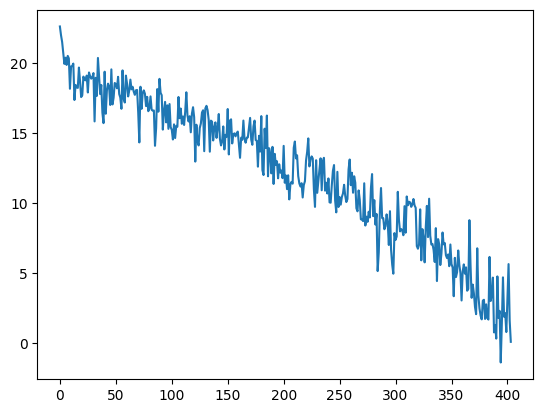

In [8]:
import matplotlib.pyplot as plt
plt.plot(np.log(train_losses))